In [2]:
import tensorflow as tf
import numpy as np
from common import *

import os, time
import tflearn
from io import StringIO
import copy
import pickle
from functools import partial
import cnn
import data_flow

from sklearn.model_selection import train_test_split

# Prepare word vectors

In [2]:
w2v_model = Word2Vec.load(join(DATA_FOLDER, 'vectors/w2v_model_300_w10'))

2017-09-08 19:14:42,298 [MainThread  ] [INFO ]  loading Word2Vec object from ../data/vectors/w2v_model_300_w10
2017-09-08 19:14:44,446 [MainThread  ] [INFO ]  loading wv recursively from ../data/vectors/w2v_model_300_w10.wv.* with mmap=None
2017-09-08 19:14:44,447 [MainThread  ] [INFO ]  loading syn0 from ../data/vectors/w2v_model_300_w10.wv.syn0.npy with mmap=None
2017-09-08 19:14:44,594 [MainThread  ] [INFO ]  setting ignored attribute syn0norm to None
2017-09-08 19:14:44,595 [MainThread  ] [INFO ]  loading syn1neg from ../data/vectors/w2v_model_300_w10.syn1neg.npy with mmap=None
2017-09-08 19:14:44,736 [MainThread  ] [INFO ]  setting ignored attribute cum_table to None
2017-09-08 19:14:44,737 [MainThread  ] [INFO ]  loaded ../data/vectors/w2v_model_300_w10


In [21]:
word_embeddings = w2v_model.wv.syn0.copy()
index2word = copy.deepcopy(w2v_model.wv.index2word)
del w2v_model

In [22]:
index2word.insert(0, 'PAD')
with open(join(DATA_FOLDER, "dictionary.pickle"), "wb") as output_file:
    pickle.dump(index2word, output_file)

In [17]:
stds = np.apply_along_axis(np.std, 1, word_embeddings)
pd.Series(stds).describe()

count    680760.000000
mean          0.193705
std           0.070574
min           0.000910
25%           0.137368
50%           0.178099
75%           0.244486
max           0.744395
dtype: float64

In [18]:
# 0.34 is chosen so the unknown vectors have (approximately) same variance as pre-trained ones
pad_vec = np.random.uniform(-0.34,0.34, word_embeddings.shape[1])
np.std(pad_vec)

0.20150940312078128

In [19]:
word_embeddings = np.insert(word_embeddings, 0, pad_vec, axis=0)

In [20]:
np.save(join(DATA_FOLDER, 'word_embeddings_%s.npy' % word_embeddings.shape[1]), word_embeddings)

# Load input data

In [3]:
word_embeddings = np.load(join(DATA_FOLDER, 'word_embeddings_300.npy'))
with open(join(DATA_FOLDER, "dictionary.pickle"), "rb") as input_file:
    index2word = pickle.load(input_file)

In [4]:
ids = glob('../data/corpus/**.txt')
with open(join(DATA_FOLDER, 'sims.json'), 'r') as f:
    sims = json.load(f)

In [9]:
triples_all = list(data_flow.random_triples(sims, ids, num_epochs=1, seed=1))
_triples, triples_test = train_test_split(triples_all, test_size=0.1, random_state=0)
triples_train, triples_val = train_test_split(_triples, test_size=0.1, random_state=0)

print(len(triples_train), len(triples_val), len(triples_test))

100%|██████████| 368458/368458 [00:06<00:00, 58370.64it/s]


(619669, 68853, 76503)


In [5]:
# triples_all = pd.read_csv(join(DATA_FOLDER, 'mpk_flow.csv.gz'), sep=' ', header=None)
# triples_all = triples_all[triples_all[2] != '59a969f1782b1b893a912539']

In [7]:
# def add_fname(_id):
#     return join(DATA_FOLDER, 'corpus', _id + '.txt')

# triples_train, triples_val, triples_test = [], [], []
# for epoch_data in np.array_split(triples_all, 3)[:1]:
#     _triples, _test = train_test_split(epoch_data, test_size=0.1, random_state=0, shuffle=False)
#     _train, _val = train_test_split(_triples, test_size=0.1, random_state=0, shuffle=False)

#     triples_train += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _train.values]
#     triples_val += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _val.values]
#     triples_test += [[add_fname(a), add_fname(b), add_fname(c)] for a,b,c in _test.values]
    
# logging.info('train %s val %s test %s' % (len(triples_train), len(triples_val), len(triples_test)))

2017-09-08 20:02:38,801 [MainThread  ] [INFO ]  train 619666 val 68852 test 76503


In [10]:
vocab_size, embedding_size = word_embeddings.shape
n_sents, n_words = 123, 40
batch_size = 64
num_epochs = 1
learning_rate=0.001

sent_filter_sizes=[1, 2, 3, 4, 5]
sent_nb_filter=10
sent_embed_size=128
sent_kmax=4

doc_filter_sizes=[1, 2, 3, 4, 5]
doc_nb_filter=10
doc_embed_size=200
doc_kmax=4

# Train

In [19]:
reload(cnn)

logging.info('start training ...')
start_time = time.time()

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            triples_train[:batch_size*3], [n_sents, n_words], 
            batch_size=batch_size, num_epochs=num_epochs)

        model = cnn.TextCNN(
            n_sents,
            n_words,
            vocab_size,
            embedding_size,
            batch_size,
            sent_filter_sizes=sent_filter_sizes,
            sent_nb_filter=sent_nb_filter,
            sent_embed_size=sent_embed_size,
            doc_filter_sizes=doc_filter_sizes,
            doc_nb_filter=doc_nb_filter,
            doc_embed_size=doc_embed_size,
            sent_kmax=sent_kmax,
            doc_kmax=doc_kmax,
            learning_rate=learning_rate)
        train_op = model.optimize(X)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        model.init_summary()
        #!!!! index is shifted by 1
        model.init_lookup_table(word_embeddings)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        try:
            while not coord.should_stop():
                _, step, loss, summary = sess.run([
                    train_op, model.global_step, model.loss_op,
                    model.merged_summary_op
                ], feed_dict = {model.phase: 1})
                model.add_summary(summary, step)
                logging.info('step %s, loss %s' % (step, loss))
        except tf.errors.OutOfRangeError:
            logging.info('Done training -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        model.save(step)
        finished = True

except Exception as e:
    logging.exception("train error")
    send_email('notebook_url', subject='train error', body=e)
finally:
    if finished:
#     send_email('notebook_url', subject='finished training')
        pass
        
logging.info("--- %s seconds ---" % (time.time() - start_time))

2017-09-12 10:22:59,030 [MainThread  ] [INFO ]  start training ...
2017-09-12 10:22:59,394 [MainThread  ] [INFO ]  sent_out_size 200, doc_out_size 200
2017-09-12 10:22:59,395 [MainThread  ] [INFO ]  sent_embed_size 128, doc_embed_size 200
2017-09-12 10:23:23,407 [MainThread  ] [INFO ]  step 1, loss 0.193281
2017-09-12 10:23:40,976 [MainThread  ] [INFO ]  step 2, loss 0.158481
2017-09-12 10:23:58,707 [MainThread  ] [INFO ]  step 3, loss 0.133083
2017-09-12 10:23:58,709 [MainThread  ] [INFO ]  Done training -- epoch limit reached
2017-09-12 10:24:01,079 [MainThread  ] [INFO ]  --- 62.0465679169 seconds ---


# Test

In [12]:
model_dir = join(DATA_FOLDER, 'models')
!ls {model_dir}

2017-09-08 18:12:19.499338-10.data-00000-of-00001
2017-09-08 18:12:19.499338-10.index
2017-09-08 18:12:19.499338-10.meta
2017-09-08 18:39:29.996515-30.data-00000-of-00001
2017-09-08 18:39:29.996515-30.index
2017-09-08 18:39:29.996515-30.meta
2017-09-08 19:32:23.886775-30.data-00000-of-00001
2017-09-08 19:32:23.886775-30.index
2017-09-08 19:32:23.886775-30.meta
2017-09-08 23:28:26.245849-3.data-00000-of-00001
2017-09-08 23:28:26.245849-3.index
2017-09-08 23:28:26.245849-3.meta
2017-09-08 23:30:22.848948-3.data-00000-of-00001
2017-09-08 23:30:22.848948-3.index
2017-09-08 23:30:22.848948-3.meta
2017-09-12 10:10:31.153943-3.data-00000-of-00001
2017-09-12 10:10:31.153943-3.index
2017-09-12 10:10:31.153943-3.meta
checkpoint


In [13]:
def chunks(l, n):
    """Yield successive n-sized chunks from l."""
    for i in range(0, len(l), n):
        yield l[i:i + n]

In [14]:
chunked = list(chunks(ids, 3))
print(chunked.pop())
logging.info('len(chunked) = %s' % len(chunked))

2017-09-12 10:10:41,858 [MainThread  ] [INFO ]  len(chunked) = 422394


['../data/corpus/5984b84fb6b1132eeb638535.txt']


In [15]:
def last_model(model_dir):
    fnames = glob(join(model_dir, '*.meta'))
    return max(fnames)

https://github.com/aymericdamien/TensorFlow-Examples/blob/master/examples/4_Utils/save_restore_model.py

In [21]:
logging.info('start testing ...')

finished = False
try:
    tf.reset_default_graph()
    tf.set_random_seed(0)
    session_conf = tf.ConfigProto(
        allow_soft_placement=True, log_device_placement=False)
    sess = tf.Session(config=session_conf)    
    with sess.as_default():
        X, fnames_batch = data_flow.input_pipeline(
            chunked[:batch_size*2], [n_sents, n_words], batch_size=batch_size, 
            num_epochs=1, shuffle=False)

        init_local = tf.local_variables_initializer()
        init_global = tf.global_variables_initializer()
        sess.run([init_global, init_local])

        # do not restore before global initialization, otherwise all weights are set to default !!!
        saver = tf.train.import_meta_graph(last_model(model_dir), input_map={'X':X})
        saver.restore(sess, tf.train.latest_checkpoint(model_dir))
        graph = tf.get_default_graph()

        op_name = 'optimize/loss/doc_embed_normalized'
        doc_embed_normalized = graph.get_operation_by_name(op_name).outputs[0]

        anchor, positive, negative = tf.unstack(
            tf.reshape(doc_embed_normalized, [-1, 3, doc_kmax * doc_nb_filter * len(doc_filter_sizes)]),
            3, 1)
        _loss = cnn.triplet_loss(anchor, positive, negative)

#         pprint([n.name for n in tf.get_default_graph().as_graph_def().node])

        doc_embeds, fnames = [], []

        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(sess=sess, coord=coord)

        step = 0
        try:
            while not coord.should_stop():
                [batch_embeds, loss, _names] = sess.run([doc_embed_normalized, 
                                                         _loss, fnames_batch])
                doc_embeds.append(batch_embeds)
                fnames += list(_names)
                logging.info('step %s, loss %s' % (step, loss))
                step+=1
        except tf.errors.OutOfRangeError:
            logging.info('Done testing -- epoch limit reached')
        finally:
            # When done, ask the threads to stop.
            coord.request_stop()

        # Wait for threads to finish.
        coord.join(threads)
        finished = True
        
except Exception as e:
    logging.exception("test error")
    send_email('notebook_url', subject='test error', body=e)
finally:
    if finished:
        send_email('notebook_url', subject='finished testing')
        pass

2017-09-12 10:24:42,511 [MainThread  ] [INFO ]  start testing ...


INFO:tensorflow:Restoring parameters from ../data/models/2017-09-12 10:23:58.720427-3


2017-09-12 10:24:44,763 [MainThread  ] [INFO ]  Restoring parameters from ../data/models/2017-09-12 10:23:58.720427-3
2017-09-12 10:24:51,607 [MainThread  ] [INFO ]  step 0, loss 0.21579
2017-09-12 10:24:57,344 [MainThread  ] [INFO ]  step 1, loss 0.221569
2017-09-12 10:24:57,346 [MainThread  ] [INFO ]  Done testing -- epoch limit reached


In [22]:
fnames = np.concatenate(fnames)
doc_embeds_reshaped = np.reshape(np.concatenate(doc_embeds), [-1, doc_embed_size])

In [23]:
len(fnames)

19200

In [130]:
test_fn = fnames[234]
test_vec = doc_embeds_reshaped[234]

In [131]:
dists = np.sum(np.square(doc_embeds_reshaped - test_vec), 1)

In [137]:
ixs = dists.argsort()[:20]
fnames[ixs]

array(['../data/corpus/5984cc8cb6b1131bd4638512.txt',
       '../data/corpus/5984c1ffb6b1132b7563853c.txt',
       '../data/corpus/5984d30db6b1135bda63851f.txt',
       '../data/corpus/5984d5fbb6b1137801638547.txt',
       '../data/corpus/5984bbddb6b1135d74638520.txt',
       '../data/corpus/5984cc50b6b1131a4b63852a.txt',
       '../data/corpus/5984b6a5b6b11316926384f9.txt',
       '../data/corpus/5984bebab6b1130130638539.txt',
       '../data/corpus/5984b6aab6b113168b63851e.txt',
       '../data/corpus/5984c21eb6b1132c8c63854a.txt',
       '../data/corpus/5984dd51b6b11333bd638515.txt',
       '../data/corpus/5984d037b6b1133d19638501.txt',
       '../data/corpus/5984d721b6b1137f2a638543.txt',
       '../data/corpus/5984c0e3b6b1131d2f638505.txt',
       '../data/corpus/5984b8eeb6b1133a506384ef.txt',
       '../data/corpus/5984b7f4b6b1132a7e63854f.txt',
       '../data/corpus/5984c6c7b6b1135e7263852a.txt',
       '../data/corpus/5984bedbb6b11302a9638538.txt',
       '../data/corpus/5984b

In [133]:
dists[ixs]

array([ 0.        ,  0.03019442,  0.03427643,  0.03450001,  0.03506924,
        0.03742333,  0.03948176,  0.0401914 ,  0.04021936,  0.0405426 ,
        0.04064511,  0.04071352,  0.04108918,  0.04140341,  0.04205039,
        0.04206143,  0.04208171,  0.04253892,  0.0425439 ,  0.04308489], dtype=float32)

In [134]:
test_fn

'../data/corpus/5984cc8cb6b1131bd4638512.txt'

In [25]:
ixs = dists.argsort()[-5:][::-1]
fnames[ixs]

array(['../data/corpus/5984c941b6b113799063851a.txt',
       '../data/corpus/5984c939b6b113799f6384fc.txt',
       '../data/corpus/5984c4efb6b1134ab1638537.txt',
       '../data/corpus/5984c538b6b1134f666384fb.txt',
       '../data/corpus/5984c92ab6b1137888638540.txt'], dtype=object)

In [136]:
[fn for fn in fnames if '5984ba98b6b1134e97638503' in fn]

['../data/corpus/5984ba98b6b1134e97638503.txt',
 '../data/corpus/5984ba98b6b1134e97638503.txt']

In [135]:
np.where(fnames == '../data/corpus/5984ba98b6b1134e97638503.txt')

(array([ 235, 9301]),)

In [183]:
with open(join(DATA_FOLDER, 'gold_mongo.json'), 'r') as f:
    gold = json.load(f)

In [212]:
best = {}
lnames = list(names)
for k in tqdm_notebook(gold.keys()):
    ix = lnames.index(add_fname(k))
    test_vec = embeds[ix]
    dists = np.sum(np.square(embeds - test_vec), 1)
    ixs = dists.argsort()[1:201]
    best[k] = [basename(n).split('.')[0] for n in names[ixs]]

median
acc10     0.0
acc20     0.0
acc200    0.0
dtype: float64
mean
acc10     0.032609
acc20     0.043478
acc200    0.114130
dtype: float64


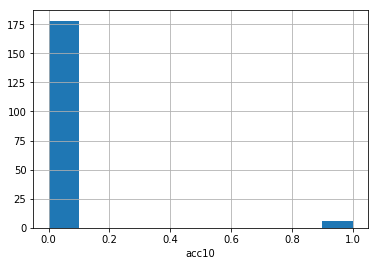

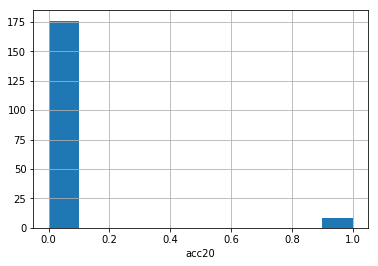

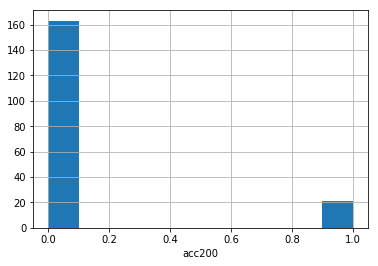

In [213]:
from matplotlib import pyplot as plt

res = evaluate(best, gold)

# Develop

In [21]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():

        dense = tf.convert_to_tensor([[1,2],[3,4]])
        
        shape = tf.shape(dense)
        dense = tf.pad(dense, [[0,10-shape[0]], [0,5-shape[1]]], 'CONSTANT')
        dense.set_shape([n_sents, n_words])

                
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([dense])
        print(res)

#         train_writer = tf.summary.FileWriter('../data/summary', sess.graph)

[[1 2 0 0 0]
 [3 4 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [0 0 0 0 0]]


In [59]:
g = tf.Graph()
with g.as_default():
    tf.set_random_seed(0)
    sess = tf.Session()
    with sess.as_default():
        
        r = list(range(100))
        ziped = zip(r[:-1], r[1:])
        t = tf.convert_to_tensor(ziped)
        
        def f(el):
            return el[0]
        
#         elems = np.array([1, 2, 3, 4, 5, 6])
#         squares = tf.map_fn(lambda x: x * x, elems)

        
        m = tf.map_fn(f, t)
            
        sess.run(tf.global_variables_initializer())
        
        [res] = sess.run([m])
        print(res)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98]


In [38]:
tt

array([[  0,   1],
       [  1,   2],
       [  2,   3],
       ..., 
       [996, 997],
       [997, 998],
       [998, 999]], dtype=int32)